# Customer churn prediction

## Requirements

In [56]:
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib import pylab, pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from operator import itemgetter
import warnings
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)

## Data loading

In [3]:
df_original = pd.read_csv("data/projeto4_telecom_treino.csv", index_col=0)
df = df_original.copy()
df_original.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


## Check data types

In [4]:
df.dtypes

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

## Encoding categorial variables

In [5]:
# state
le = LabelEncoder()
state_map = dict(
    sorted(set(list(zip(df_original.state, le.fit_transform(df_original.state))))))
df['state'] = le.fit_transform(df_original.state)

# international_plan, voice_mail_plan and churn
mapping = {"yes": 1, "no": 0}
columns = ["international_plan", "voice_mail_plan", "churn"]

for column in columns:
    df[column] = df_original[column].map(mapping)

# area_code
df['area_code'] = df_original['area_code'].str.replace(
    "area_code_", "").astype(int)

In [6]:
df.dtypes

state                              int32
account_length                     int64
area_code                          int32
international_plan                 int64
voice_mail_plan                    int64
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                              int64
dtype: object

## Exploratory Data Analysis

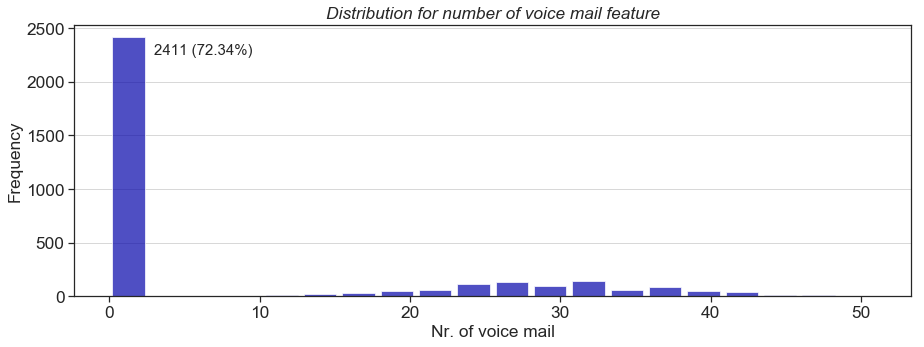

In [7]:
# Histogram for 'number_vmail_messages' feature

zero_count = df['number_vmail_messages'].value_counts()[0]
zero_count_percent = df['number_vmail_messages'] \
    .value_counts(normalize=True)[0].round(4)*100

plt.hist(x=df["number_vmail_messages"], bins="auto",
         color="#0504aa", alpha=0.7, rwidth=0.85)

plt.grid(axis="y", alpha=0.75)
plt.xlabel("Nr. of voice mail")
plt.ylabel("Frequency")
plt.title("Distribution for number of voice mail feature", style='italic')
plt.text(x=3, y=2250, s=f"{zero_count} ({zero_count_percent}%)", fontsize=15)
plt.show()

**Insight:** There seems to be an outlier. The question is: why there are 72.34% of 0 values at number of voice mail feature? Maybe because nobody send voice mail today, or the persons end the call before leaving any voice mail?

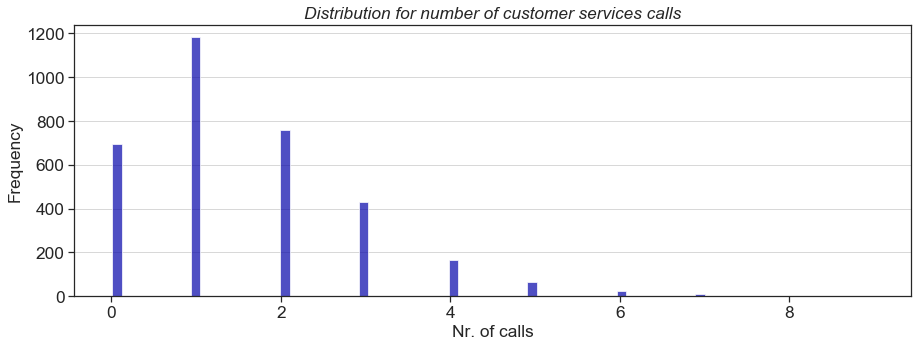

In [8]:
# Histogram for 'number_customer_service_call' feature

plt.hist(x=df["number_customer_service_calls"], bins="auto",
         color="#0504aa", alpha=0.7, rwidth=0.85)
plt.grid(axis="y", alpha=0.75)
plt.xlabel("Nr. of calls")
plt.ylabel("Frequency")
plt.title("Distribution for number of customer services calls", style='italic')
plt.show()

**Insight:** Most persons made 1 call to customer services in this dataset, followed by 2 calls and no calls. This should be an point to explore more of this feature, especially how it's related to target churn.

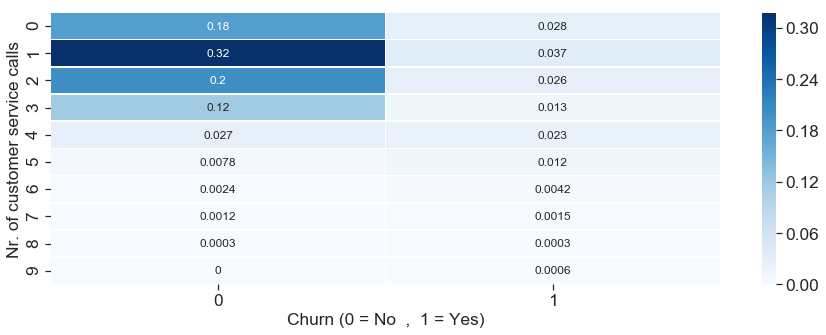

In [9]:
# Contingency table number_customer_service_calls x churn
contingency_table = pd.crosstab(index=df['number_customer_service_calls'],
                                columns=df['churn'],
                                normalize=True)

# Chart of cintingency table
ax = sns.heatmap(contingency_table, annot=True, linewidths=.5, cmap="Blues")
plt.ylabel("Nr. of customer service calls")
plt.xlabel("Churn (0 = No  ,  1 = Yes)")
plt.show()

**Insight:** 3,7% of churned customers did one call to customer serices. Perhaps a bad servide at first call leaded customer to abandon the service? And why 32% of customers which decided to continued make one call to customer service? 

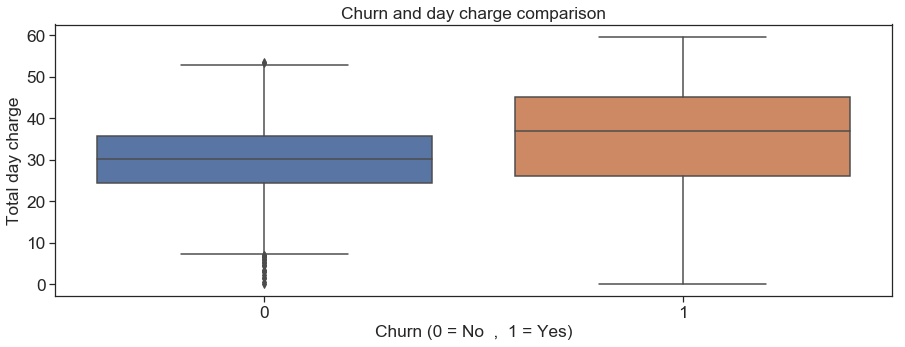

In [10]:
# Boxplot of daily charges vs churn
ax = sns.boxplot(data=df, x="churn", y="total_day_charge")
plt.ylabel("Total day charge")
plt.xlabel("Churn (0 = No  ,  1 = Yes)")
plt.title("Churn and day charge comparison")
plt.show()

**Insight**: The daily charge mean value for customers that abandoned the service is higher than those who did not left the service. This could be one possible reason why customers decided to discontinue it. Maybe the service where to expensive for them or they are facing financial difficulties.

[]

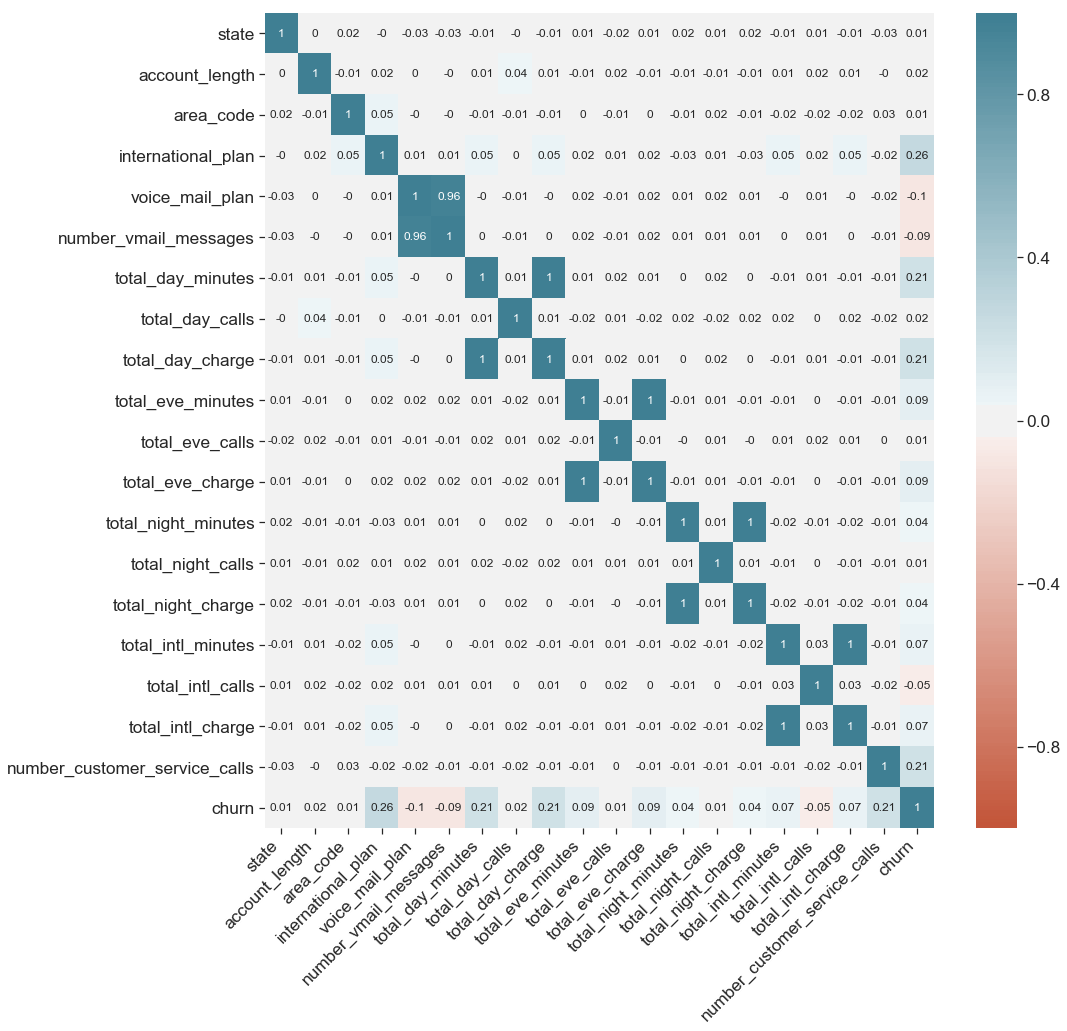

In [11]:
# Plot of correlation matrix

corr = df.corr().round(2)
plt.figure(figsize=(15, 15))

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

plt.plot()

In [23]:
# Function to train model and get accuracy
def train_model_get_accuracy(X_train, y_train, X_test, y_test, seed=50):

    # Training the model
    model = LogisticRegression(random_state=seed, penalty='l2')
    model.fit(X_train, y_train)
    
    # Score in test data
    result = model.score(X_test, y_test)
    print(f"Accurary in test data: {result * 100:.2f} %")

## Training model with complete dataset

In [24]:
# Features and target of train data
X_train = df[df.columns.difference(['churn'])]
y_train = df['churn']

# Load test data
df_test = pd.read_csv("data/projeto4_telecom_teste.csv", index_col=0)

# Test data transformations (same as train data)
le = LabelEncoder()
state_map = dict(
    sorted(set(list(zip(df_test.state, le.fit_transform(df_test.state))))))
df_test['state'] = le.fit_transform(df_test.state)

mapping = {"yes": 1, "no": 0}
columns = ["international_plan", "voice_mail_plan", "churn"]

for column in columns:
    df_test[column] = df_test[column].map(mapping)

df_test['area_code'] = df_test['area_code'].str.replace(
    "area_code_", "").astype(int)

# Features and target of test data
X_test = df_test[df.columns.difference(['churn'])]
y_test = df_test['churn']

features = X_train.columns

In [25]:
# Complete dataset with no transformation
train_model_get_accuracy(X_train, y_train, X_test, y_test)

Accurary in test data: 86.92 %


## Data transformation

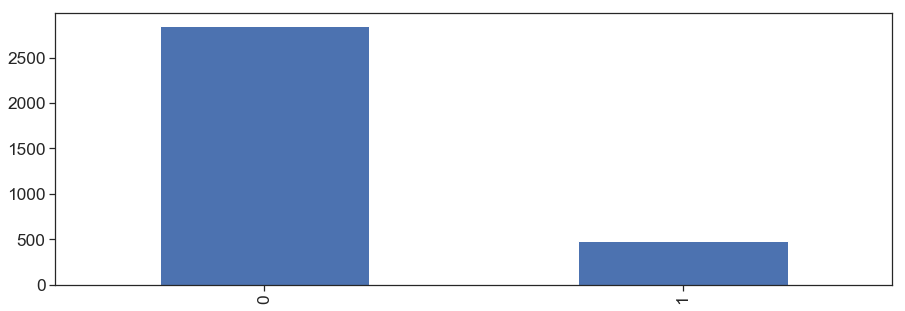

In [26]:
# Check the balance of target classes
y_train.value_counts().plot(kind='bar')
plt.show()

**Transformation:** I'll apply SMOTE technique for balancing target classes.

In [30]:
# Applying SMOTE technique for class balancing
smt = SMOTE(random_state=50)
X_train_smote, y_train_smote = smt.fit_sample(X_train, y_train)

X_test_smote, y_test_smote = smt.fit_sample(X_test, y_test)

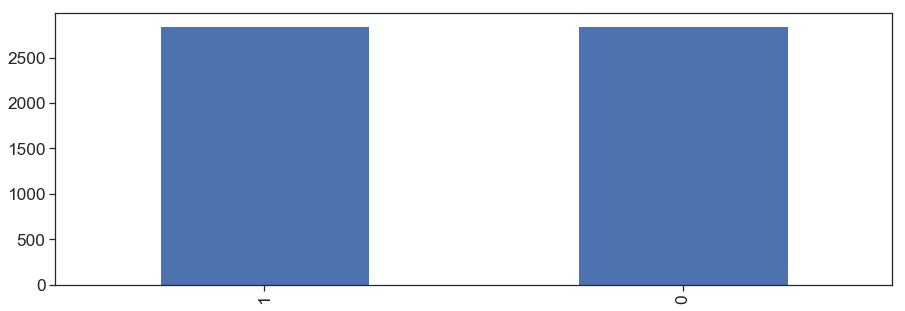

In [31]:
# Checking balance after SMOTE
y_train_smote.value_counts().plot(kind='bar')
plt.show()

## Model training after transformations

In [32]:
# Train model with complete dataset
train_model_get_accuracy(X_train_smote, y_train_smote, X_test_smote, y_test_smote)

Accurary in test data: 68.57 %


**Bad decision:** SMOTE technique reduced the accuracy of model from 85% to 68%! Maybe because of the low number of observations in dataset...

## Performance optimization

In [34]:
# Feature selection with Extra Trees Classifier
ETC = ExtraTreesClassifier(random_state=50)
ETC.fit(X_train, y_train)
feat_imp = dict(zip(features, ETC.feature_importances_.round(4)))

sorted(feat_imp.items(), key=itemgetter(1), reverse=True)

[('total_day_minutes', 0.1267),
 ('number_customer_service_calls', 0.1237),
 ('total_day_charge', 0.1215),
 ('international_plan', 0.0748),
 ('total_eve_minutes', 0.056),
 ('total_eve_charge', 0.0534),
 ('total_intl_calls', 0.0503),
 ('total_intl_minutes', 0.0453),
 ('total_intl_charge', 0.0441),
 ('total_night_charge', 0.0373),
 ('total_night_minutes', 0.0363),
 ('total_day_calls', 0.0351),
 ('account_length', 0.0336),
 ('total_night_calls', 0.0336),
 ('total_eve_calls', 0.0332),
 ('state', 0.0321),
 ('area_code', 0.0234),
 ('voice_mail_plan', 0.0213),
 ('number_vmail_messages', 0.0182)]

**Decision:** I'll train another model using the 2 top classified features, according to result above

In [35]:
# Selecting 2 best classified features
X_top2_fs_train = X_train[['total_day_charge', 'number_customer_service_calls']]
X_top2_fs_test = X_test[['total_day_charge', 'number_customer_service_calls']]

# Accuracy of trained model
train_model_get_accuracy(X_top2_fs_train, y_train, X_top2_fs_test, y_test)

Accurary in test data: 86.44 %


**Decision:** I'll train another model using the 5 top classified features.

In [36]:
# Selecting 5 best classified features
X_top5_fs_train = X_train[['total_day_minutes',
                           'number_customer_service_calls',
                           'total_day_charge',
                           'international_plan',
                           'total_eve_minutes']]

X_top5_fs_test = X_test[['total_day_minutes',
                         'number_customer_service_calls',
                         'total_day_charge',
                         'international_plan',
                         'total_eve_minutes']]

# Accuracy of trained model
train_model_get_accuracy(X_top5_fs_train, y_train, X_top5_fs_test, y_test)

Accurary in test data: 87.04 %


**Decision:** The model with 5 features gave us an acceptable accuracy. Let's see what is the influence of normalization and standartization on them.

In [37]:
# Applying normalization to the 5 features
X_top5_fs_norm_train = normalize(X_top5_fs_train)
X_top5_fs_norm_test = normalize(X_top5_fs_test)

# Accuracy of trained model
train_model_get_accuracy(X_top5_fs_norm_train, y_train, X_top5_fs_norm_test, y_test)

Accurary in test data: 86.56 %


In [42]:
# Applying normalization to the 5 features
scaler = StandardScaler()
X_top5_fs_z_train = scaler.fit_transform(X_top5_fs_train)
X_top5_fs_z_test = scaler.fit_transform(X_top5_fs_test)

# Accuracy of trained model
train_model_get_accuracy(X_top5_fs_z_train, y_train, X_top5_fs_z_test, y_test)

Accurary in test data: 86.86 %


## Hyperparameters tuning

In [43]:
# Defining some grid parameters to test
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5,3.0,3.5]

param_grid = dict(dual=dual,max_iter=max_iter,C=C)

In [48]:
model = LogisticRegression(random_state=50, penalty='l2')
model.fit(X_top5_fs_train, y_train)

random = RandomizedSearchCV(estimator=model, param_distributions=param_grid)
random_result = random.fit(X_top5_fs_test, y_test)
print(f"Best accuracy: {random_result.best_score_*100:.2f}% using {random_result.best_params_}")

Best accuracy: 86.68% using {'max_iter': 120, 'dual': False, 'C': 1.0}


## Final model

In [49]:
# Training the model
model = LogisticRegression(random_state=50,
                           max_iter=120,
                           dual=False,
                           C=1.0)
model = LogisticRegression(random_state=50, penalty='l2')
model.fit(X_top5_fs_train, y_train)

# Score with test data
result = model.score(X_top5_fs_test, y_test)
print(f"Accurary in test data: {result * 100:.2f} %")

Accurary in test data: 87.04 %


## Predictions, confusion matrix and probabilities

In [64]:
pred = model.predict(X_top5_fs_test); pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

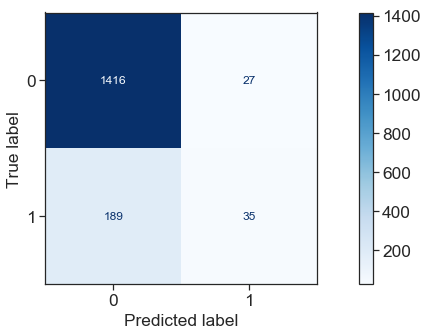

In [70]:
plot_confusion_matrix(model, X_top5_fs_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.show()

In [77]:
print(model.classes_)
print(model.predict_proba(X_top5_fs_test) * 100)

[0 1]
[[95.03162942  4.96837058]
 [91.03338307  8.96661693]
 [72.92398395 27.07601605]
 ...
 [96.47886609  3.52113391]
 [96.11580137  3.88419863]
 [96.60624393  3.39375607]]
